---
title: Time resolution effect Analysis
abstract: To understand if the difference of Juno distribution at 1AU and beyond is due to time resolution, i.e. it's possile that 1 s is sufficient to resolve distribution at r > 5AU, but insufficient at 1AU. To check this we may compare ARTEMIS data at 1AU for two resolutions - 1 s and 1/5 s
---

In [1]:
import polars as pl
import polars.selectors as cs

In [2]:
#| hide

from beforerr.r import py2rpy_polars
import rpy2.robjects as robjects

%load_ext rpy2.ipython

r = robjects.r
r.source('utils.R')

conv_pl = py2rpy_polars()

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘scales’


R[write to console]: The following object is masked from ‘package:purrr’:

    discard




In [6]:
ts = 1.00 # unit: seconds
tau = 60 # unit: seconds
data_dir = "../data"
format = "arrow"

In [11]:
parameters = ['j0_k', 'j0_k_norm', 'L_k', 'L_k_norm']

juno_fit = pl.read_ipc(f"{data_dir}/05_reporting/events.JNO.fit.ts_{ts:.2f}s_tau_{tau}s.arrow").with_columns(
    pl.col(parameters).abs(),
).with_columns(cs.numeric().cast(pl.Float64)).drop_nulls().filter(
    pl.col("d_star") < 100,  # exclude extreme values
    pl.col('j0_k') < 100
).with_columns(pl.col('count').cast(pl.UInt32)).lazy()

ColumnNotFoundError: count

Error originated just after this operation:
DF ["time", "tstart", "tstop", "t.d_end"]; PROJECT */92 COLUMNS; SELECTION: "None"

In [12]:
parameters = ['j0', 'j0_norm', 'j0_k', 'j0_k_norm', 'L_mn', 'L_k', 'L_mn_norm', 'L_k_norm']

wind_fit = pl.read_ipc(f"{data_dir}/05_reporting/events.Wind.ts_{ts}s_tau_{tau}s.arrow").with_columns(
    pl.col(parameters).abs(),
).with_columns(cs.numeric().cast(pl.Float64)).drop_nulls().filter(
    pl.col("d_star") < 100,  # exclude extreme values
    pl.col('j0') < 100
).with_columns(pl.col('count').cast(pl.UInt32)).lazy()

FileNotFoundError: No such file or directory (os error 2): ../data/05_reporting/events.Wind.ts_1.0s_tau_60s.arrow

In [13]:
def load_events(name: str, ts: float, tau: float, method ='derivative') -> pl.DataFrame:
    if method == 'derivative':
        format = 'parquet'
        filepath = f"{data_dir}/08_reporting/events/l1/{name}_ts_{ts}s_tau_{tau}s.{format}"
        df = pl.scan_parquet(filepath)
    elif method == 'fit':
        format = 'arrow'
        filepath = f"{data_dir}/05_reporting/events.{name}.ts_{ts:.2f}s_tau_{tau}s.{format}"
        df = pl.read_ipc(filepath).lazy()
    return df.with_columns(
        pl.col(parameters).abs(),
        sat = pl.lit(name),
        ts = pl.lit(f'{ts}s'),
        method = pl.lit(method),
        ts_method = pl.lit(f'{ts}s {method}'),
        label = pl.lit(f'{name} {ts}s {method}')
    ).with_columns(cs.numeric().cast(pl.Float64))

In [14]:
wind_ts_009_all = load_events('Wind', 0.09, 60)
wind_ts_01_all = load_events('Wind', 0.1, 60)
wind_ts_02_all = load_events('Wind', 0.2, 60)
wind_ts_05_all = load_events('Wind', 0.5, 60)
wind_ts_1_all = load_events('Wind', 1, 60)

juno_ts_1_all = load_events('JNO', 1, 60)
juno_ts_1_fit = load_events('JNO', 1, 60, method='fit')


wind_ts_01_fit = load_events('Wind', 0.09, 60, method='fit')
wind_ts_02_fit = load_events('Wind', 0.2, 60, method='fit')
wind_ts_05_fit = load_events('Wind', 0.5, 60, method='fit')
wind_ts_1_fit = load_events('Wind', 1, 60, method='fit')
wind_ts_2_fit = load_events('Wind', 2, 60, method='fit')

wind_fit_dfs = [wind_ts_01_fit, wind_ts_02_fit, wind_ts_05_fit, wind_ts_1_fit, wind_ts_2_fit]

In [16]:
wind_ts_01_fit

<LazyFrame [88 cols, {"time": Datetime(time_unit='ns', time_zone=None) … "label": String}] at 0x28FCCC9D0>

In [25]:
time_filter = pl.col('time').dt.year()==2016
dfs = [juno_ts_1_all, wind_ts_1_all, juno_ts_1_fit, wind_ts_009_all, wind_ts_01_all, wind_ts_02_all, wind_ts_05_all] + wind_fit_dfs

df = pl.concat([_.filter(time_filter) for _ in dfs], how='diagonal').collect()
%R -i df -c conv_pl

In [26]:
%%R
filename <- "ts_effect"
filename <- "ts_effect_new"

In [80]:
%%R
# sort color with 'JUNO 1s' first
plot_ts_effect <- function(df, labels=NULL, color ="label", L_mn_norm_lim = c(0,60), j_norm_lim = c(0,0.8), legend_title = NULL) {

  # if labels is not null, select df with labels and reorder labels
  if (!is.null(labels)){
    df <- df %>%
      filter(label %in% labels) %>%
      mutate(label = factor(label, levels = labels))
  }

  
  add <- "mean" # this seems to be computed before the limits are set
  add <- NULL
  
  common_custom <- scale_color_okabeito(palette = "black_first")

  x <- "L_mn"
  x_lim <- c(0,7500)
  p1 <- ggdensity(df, x = x, color = color, add = add, alpha = 0) + xlim(x_lim) + common_custom

  x <- "L_mn_norm"
  x_lab <- expression(paste("Normalized Thickness (", d[i], ")"))
  p2 <- ggdensity(df, x = x, color = color, add = add, alpha = 0) + xlim(L_mn_norm_lim) + common_custom + labs(x=x_lab)

  x <- "j0"
  x_lim <- c(0,20)
  p3 <- ggdensity(df, x = x, color = color, add = add, alpha = 0) + xlim(x_lim) + common_custom

  x <- "j0_norm"
  x_lab <- expression(paste("Normalized Current Intensity (", J[A], ")"))
  p4 <- ggdensity(df, x = x, color = color, add = add, alpha = 0) + xlim(j_norm_lim) + common_custom + labs(x=x_lab)


  output <- list(p2, p4)
  # change the legend title for each plot
  if (!is.null(legend_title)){
    for (i in 1:length(output)){
      output[[i]] <- ggpar(output[[i]], legend.title = legend_title)
    }
  }

  purrr::reduce(output, `+`) + plot_layout(guides = 'collect', nrow=2) &
    theme(legend.position='top')
}



R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 12428 rows containing non-finite values (`stat_density()`). 

R[write to console]: 2: Removed 1 rows containing missing values (`geom_vline()`). 

R[write to console]: 3: Removed 719 rows containing non-finite values (`stat_density()`). 



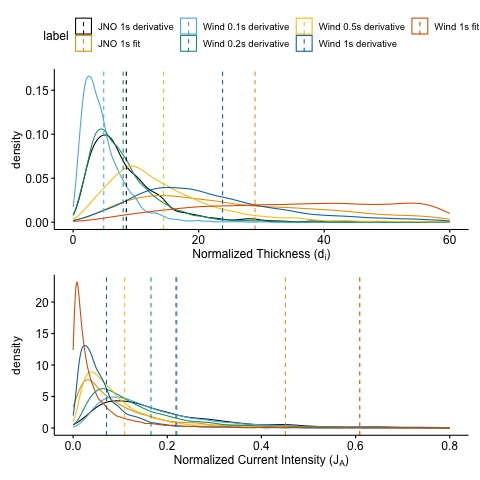

In [20]:
%%R
filename <- "ts_method/all"
p <- plot_ts_effect(df)
save_plot(filename)
p

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 12233 rows containing non-finite values (`stat_density()`). 

R[write to console]: 2: Removed 658 rows containing non-finite values (`stat_density()`). 

R[write to console]: 3: Removed 195 rows containing non-finite values (`stat_density()`). 

R[write to console]: 4: Removed 61 rows containing non-finite values (`stat_density()`). 



In addition: Warning messages:
1: Removed 12233 rows containing non-finite values (`stat_density()`). 
2: Removed 658 rows containing non-finite values (`stat_density()`). 
3: Removed 12233 rows containing non-finite values (`stat_density()`). 
4: Removed 658 rows containing non-finite values (`stat_density()`). 
5: Removed 195 rows containing non-finite values (`stat_density()`). 
6: Removed 61 rows containing non-finite values (`stat_density()`). 
7: Removed 195 rows containing non-finite values (`stat_density()`). 
8: Removed 61 rows containing non-finite values (`stat_density()`). 


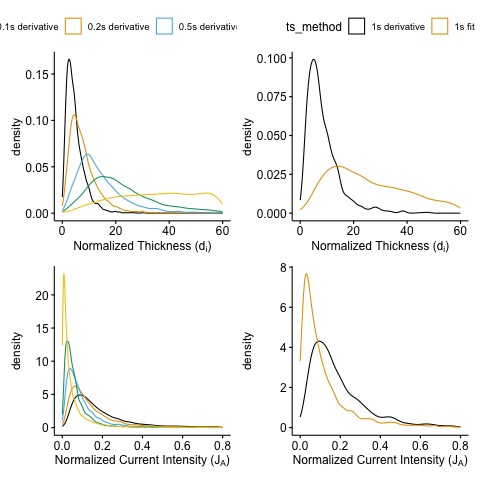

In [44]:
%%R
# filter df with sat = 'Wind'
p1 <- df %>%
  filter(sat == 'Wind') %>%
    plot_ts_effect(color = "ts_method")

filename <- "ts_method/wind"
save_plot(filename)

p2 <- df %>%
  filter(sat == 'JNO') %>%
    plot_ts_effect(color = "ts_method")
    
filename <- "ts_method/juno"
save_plot(filename)

p1 | p2

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 4927 rows containing non-finite values (`stat_density()`). 

R[write to console]: 2: Removed 3013 rows containing non-finite values (`stat_density()`). 



In addition: Warning messages:
1: Removed 4927 rows containing non-finite values (`stat_density()`). 
2: Removed 3013 rows containing non-finite values (`stat_density()`). 
3: Removed 4927 rows containing non-finite values (`stat_density()`). 
4: Removed 3013 rows containing non-finite values (`stat_density()`). 


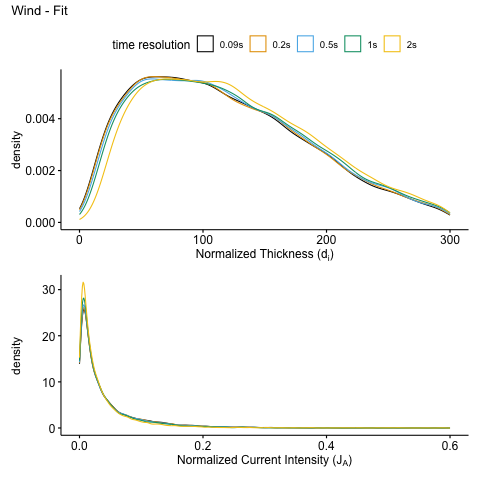

In [82]:
%%R
p <- df %>%
  filter(method == 'fit', sat == 'Wind') %>%
    plot_ts_effect(color = 'ts', L_mn_norm_lim = c(0,300), j_norm_lim = c(0,0.6), legend_title = "time resolution")

p <- p + plot_annotation(title = "Wind - Fit")

filename <- "ts_method/wind_fit"
save_plot(filename)
p


Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 334 rows containing non-finite values (`stat_density()`). 

R[write to console]: 2: Removed 502 rows containing non-finite values (`stat_density()`). 

R[write to console]: 3: Removed 335 rows containing non-finite values (`stat_density()`). 

R[write to console]: 4: Removed 313 rows containing non-finite values (`stat_density()`). 



In addition: Warning messages:
1: Removed 334 rows containing non-finite values (`stat_density()`). 
2: Removed 502 rows containing non-finite values (`stat_density()`). 
3: Removed 334 rows containing non-finite values (`stat_density()`). 
4: Removed 502 rows containing non-finite values (`stat_density()`). 
5: Removed 335 rows containing non-finite values (`stat_density()`). 
6: Removed 313 rows containing non-finite values (`stat_density()`). 
7: Removed 335 rows containing non-finite values (`stat_density()`). 
8: Removed 313 rows containing non-finite values (`stat_density()`). 


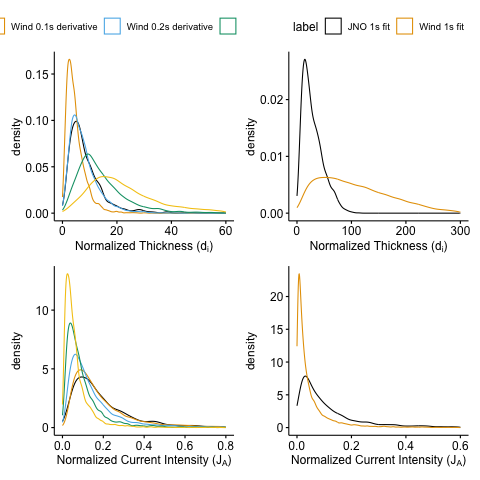

In [45]:
%%R
p1 <- df %>%
  filter(method == 'derivative') %>%
    plot_ts_effect
 
filename <- "ts_method/derivative"
save_plot(filename)
p1

p2 <- df %>%
  filter(method == 'fit') %>%
    plot_ts_effect(L_mn_norm_lim = c(0,300), j_norm_lim = c(0,0.6))

filename <- "ts_method/fit"
save_plot(filename)
p2

p1 | p2